In [1]:
#loading python librairies
import pandas as pd
from pandas.core.common import flatten
import numpy as np
import seaborn as sns
import unicodedata
from tqdm.notebook import tqdm_notebook

from matplotlib import pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,RNN,Dropout,GlobalAveragePooling1D,Dense,GRUCell
from tensorflow.keras import callbacks
from tensorflow.keras import models

import mlflow
import mlflow.keras
import mlflow.tensorflow

In [2]:
#loading data set
#The data set is available here : https://www.kaggle.com/kazanova/sentiment140
df=pd.read_csv("C:/Users/Sevil/Desktop/datascientest/data_sets/corpus_sentiment_analysis/train.csv",encoding="latin-1",header = None)

df.columns=['sentiment', 'id', 'date', 'query', 'user', 'tweet']
df = df.drop(columns=['id', 'date', 'query', 'user'], axis=1)
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
#replacing the label 4 with 1 
df["sentiment"]= df["sentiment"].replace(4,1)
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
#counting des number of labels and their frequencies in data set
df["sentiment"].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

In [5]:
#counting the pourcentage of each label
df["sentiment"].value_counts(normalize=True)

0    0.5
1    0.5
Name: sentiment, dtype: float64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

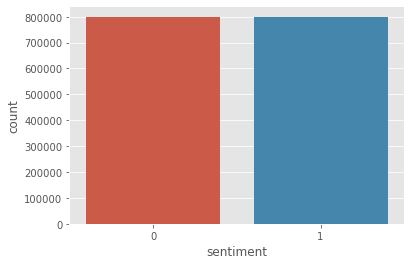

In [6]:
#shwoing the proportion of labels in data set
plt.style.use('ggplot')
sns.countplot(x="sentiment",data=df)

In [7]:
#Cleaning the data set
stop_words = stopwords.words('english')

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)
    #removing the linkes
    w = re.sub(r"https?://[a-zA-Z0-9./]+", " ", w)
    #removing mails
    w = re.sub(r"[a-zA-Z0-9.-]+@[a-zA-Z.]+", " ", w)
    #removing htags
    w = re.sub(r"#[a-zA-Z0-9]+", "_", w)
    w = re.sub(r"@[a-zA-Z0-9]+", " ", w)
    # remove stopword
    words = word_tokenize(w.strip())
    words = [mot for mot in words if mot not in stop_words]
    return words

tqdm_notebook.pandas()
df["tweet"]= df["tweet"].progress_apply(lambda x :preprocess_sentence(x))
df.head()

  0%|          | 0/1600000 [00:00<?, ?it/s]

,sentiment,tweet
0,0,"[switchfoot, http, twitpic, com, awww, bummer,..."
1,0,"[upset, update, facebook, texting, might, cry,..."
2,0,"[kenichan, dived, many, times, ball, managed, ..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[nationwideclass, behaving, mad, see]"


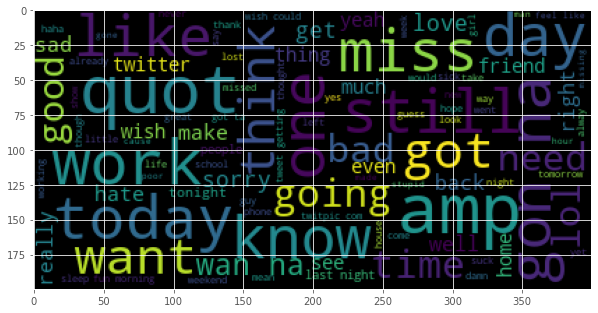

In [9]:
#word cloud for the tweets with sentiment=0
wc=WordCloud(background_color="black",max_words=100,stopwords=stop_words,max_font_size=50)
text_0=""

for comment in df["tweet"][df["sentiment"]==0]:
    comment=' '.join(comment)
    text_0+=comment

plt.figure(figsize= (10,6)) 
wc.generate(text_0)           
plt.imshow(wc) 
plt.show()

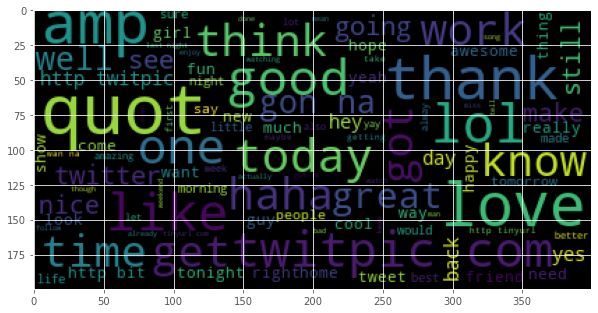

In [10]:
#word cloud for the tweets with sentiment=1
text_1=""
for comment in df["tweet"][df["sentiment"]==1]:
    comment=' '.join(comment)
    text_1+=comment


plt.figure(figsize= (10,6)) 
wc.generate(text_1)           
plt.imshow(wc) 
plt.show()

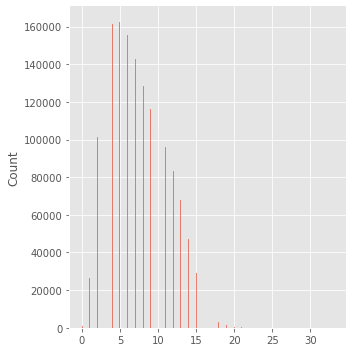

In [11]:
#plot distribution for the lenght of tweets
sns.displot(list(map(len,df["tweet"])))

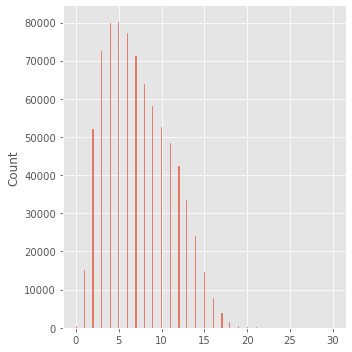

In [12]:
#plot distribution for the tweet lenghts with sentiment=0
sns.displot(list(map(len,df["tweet"][df["sentiment"]==0])))

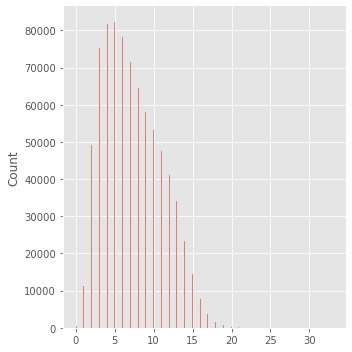

In [13]:
#plot distribution for the tweet lenghts with sentiment=1
sns.displot(list(map(len,df["tweet"][df["sentiment"]==1])))

In [14]:
#dividing the data set into test and train
X_train, X_test, y_train, y_test = train_test_split(df["tweet"], df["sentiment"], test_size=0.2, random_state=1234)

In [15]:
#vectorizing tweets
words_unique=list(set(flatten(df["tweet"].values)))
print(len(words_unique))

tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

X_train=pad_sequences(X_train,maxlen=20,padding="post",truncating="post")
X_test=pad_sequences(X_test,maxlen=20,padding="post",truncating="post")

In [16]:
#definig our RNN model
words_unique=list(set(flatten(df["tweet"].values)))
num_words=len(words_unique)
max_len = 20
print(num_words)

model=Sequential()
model.add(Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len))
model.add(RNN(GRUCell(128),return_sequences=True))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2,activation="sigmoid"))
model.summary()

586526
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 20)            11730520  
_________________________________________________________________
rnn (RNN)                    (None, 20, 128)           57600     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)           

In [17]:
#compiling the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#definig the callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                             patience = 2,
                                             factor = 0.2,
                                             verbose = 2,
                                             mode = 'min',
                                             min_lr=0)
early_stopping = callbacks.EarlyStopping(monitor = "loss",
                                             patience = 3,
                                             mode = 'min',
                                             verbose = 2,
                                             restore_best_weights= True)
checkpoint = callbacks.ModelCheckpoint(filepath="C:/Users/Sevil/Desktop/datascientest/data_sets/corpus_sentiment_analysis/check",
                                          monitor = 'loss',
                                          save_best_only = True,
                                          save_weights_only = False,
                                          mode = 'min',
                                          save_freq = 'epoch')

In [23]:
mlflow.set_experiment("sentiment_analysis")
epochs=10
with mlflow.start_run() as run:
    
    history = model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test,y_test),callbacks=[lr_plateau,early_stopping, checkpoint],use_multiprocessing= True,batch_size=100)
    
    mlflow.tensorflow.autolog(every_n_iter=1)
    
    probs = model.predict(X_test)
    y_pred = np.argmax(probs, axis=1)
    fscore=f1_score(y_test,y_pred)   
    mlflow.log_metric("f1-score",fscore)
    mlflow.log_param("epochs",epochs)
    model_name = "sentiment_analysis"
    artifact_path="artifacts"
    mlflow.keras.log_model(keras_model=model, artifact_path=artifact_path)
    mlflow.keras.save_model(keras_model=model, path=model_name)
    mlflow.log_artifact(local_path=model_name)
    runID=run.info.run_uuid
    mlflow.register_model("runs:/"+runID+"/"+artifact_path,"sentiment_analysis")
 

Epoch 1/10
12800/12800 [==============================] - 1402s 110ms/step - loss: 0.3625 - accuracy: 0.8347 - val_loss: 0.5072 - val_accuracy: 0.7718
INFO:tensorflow:Assets written to: C:/Users/Sevil/Desktop/datascientest/data_sets/corpus_sentiment_analysis\check\assets
Epoch 2/10
12800/12800 [==============================] - 1412s 110ms/step - loss: 0.3567 - accuracy: 0.8376 - val_loss: 0.5340 - val_accuracy: 0.7726
INFO:tensorflow:Assets written to: C:/Users/Sevil/Desktop/datascientest/data_sets/corpus_sentiment_analysis\check\assets
Epoch 3/10
12800/12800 [==============================] - 1419s 111ms/step - loss: 0.3518 - accuracy: 0.8398 - val_loss: 0.5322 - val_accuracy: 0.7697
INFO:tensorflow:Assets written to: C:/Users/Sevil/Desktop/datascientest/data_sets/corpus_sentiment_analysis\check\assets
Epoch 4/10
12800/12800 [==============================] - 1416s 111ms/step - loss: 0.3473 - accuracy: 0.8419 - val_loss: 0.5550 - val_accuracy: 0.7684
INFO:tensorflow:Assets written to

Successfully registered model 'sentiment_analysis_big_dataset_3'.
2021/11/12 14:38:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sentiment_analysis_big_dataset_3, version 1
Created version '1' of model 'sentiment_analysis_big_dataset_3'.


In [24]:
#model evaluation
model.evaluate(X_test,y_test.values,batch_size=128)

2500/2500 [==============================] - 20s 8ms/step - loss: 0.5743 - accuracy: 0.7646


[0.5743131637573242, 0.7646155953407288]

Predicted       0       1
Actual                   
0          120734   39346
1           35977  123943
              precision    recall  f1-score   support

           0       0.77      0.75      0.76    160080
           1       0.76      0.78      0.77    159920

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



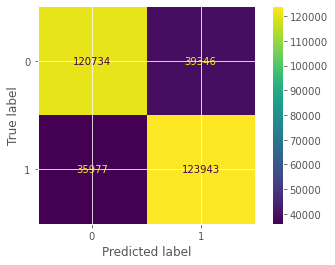

In [25]:
#confusion matrix
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(conf_matrix)
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])

disp.plot()
plt.show()

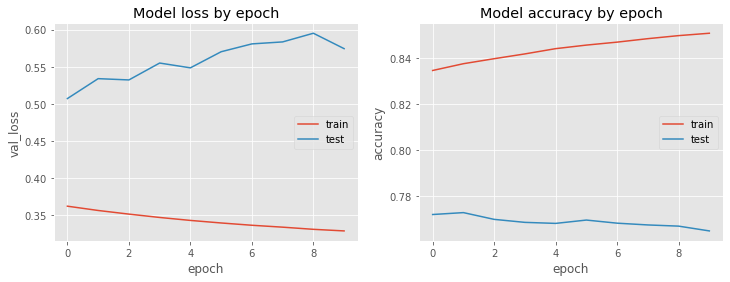

In [26]:
#plot loss and accuracy for test and train

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()